# [Python Encoding Guide](https://realpython.com/python-encodings-guide/)

# What's character encoding?
It encompasses the following:

- Lowercase English letters: a through z
- Uppercase English letters: A through Z
- Some punctuation and symbols: "$" and "!", to name a couple
- Whitespace characters: an actual space (" "), as well as a newline, carriage return, horizontal tab, vertical tab, and a few others
- Some non-printable characters: characters such as backspace, "\b", that can’t be printed literally in the way that the letter A can


So what is a more formal definition of a character encoding?

At a very high level, it’s a way of translating characters (such as letters, punctuation, symbols, whitespace, and control characters) to integers and ultimately to bits. 
Each character can be encoded to a unique sequence of bits. 
Don’t worry if you’re shaky on the concept of bits, because we’ll get to them shortly.

The various categories outlined represent groups of characters. Each single character has a corresponding code point, which you can think of as just an integer. 
Characters are segmented into different ranges within the ASCII table:


Code  Point Range	 | Class
-------------------|------
0 through 31	| Control/non-printable characters
32 through 64	| Punctuation, symbols, numbers, and space
65 through 90	| Uppercase English alphabet letters
91 through 96	| Additional graphemes, such as [ and \\
97 through 122 |	Lowercase English alphabet letters
123 through 126	|Additional graphemes, such as { and \|
127	| Control/non-printable character (DEL)

The entire ASCII table contains 128 characters. 
This table captures the complete character set that ASCII permits. 
If you don’t see a character here, then you simply can’t express it as printed text under the ASCII encoding scheme.

In [1]:
# From lib/python3.7/string.py
from icecream import ic

whitespace = " \t\n\r\v\f"
ascii_lowercase = "abcdefghijklmnopqrstuvwxyz"
ascii_uppercase = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
ascii_letters = ascii_lowercase + ascii_uppercase

digits = "0123456789"
hexdigits = digits + "abcdef" + "ABCDEF"
octdigits = "01234567"

punctuation = r"""!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~"""

printable = digits + ascii_letters + punctuation + whitespace

In [2]:
import string

s = "What's wrong with ASCII?!?!?"
s.rstrip(string.punctuation)

"What's wrong with ASCII"

**Note**: string.printable includes all of `string.whitespace`. This disagrees slightly with another method for testing whether a character is considered printable, namely `str.isprintable()`, which will tell you that none of {'\v', '\n', '\r', '\f', '\t'} are considered printable.

The subtle difference is because of definition: `str.isprintable()` considers something printable if “all of its characters are considered printable in `repr()`.”

In [3]:
print(string.whitespace.__repr__())

(string.whitespace, string.ascii_lowercase)

' \t\n\r\x0b\x0c'


(' \t\n\r\x0b\x0c', 'abcdefghijklmnopqrstuvwxyz')

In [4]:
for i in string.whitespace:
    print(str.isprintable(i))

True
False
False
False
False
False


Here’s a handy way to represent ASCII strings as sequences of bits in Python. 
- Each character from the ASCII string gets **pseudo-encoded** into 8 bits, with spaces in between the 8-bit sequences that each represent a single character:
- `ord` return the unicode code point for a one-character string

In [5]:
def make_bitseq(s: str) -> str:
    if not s.isascii():
        raise ValueError("ASCII only allowed")
    return " ".join(f"{ord(i):08b}" for i in s)


make_bitseq("bits")

'01100010 01101001 01110100 01110011'

In [6]:
from icecream import ic

ic(string.ascii_letters)
str.isascii("]")

ic| string.ascii_letters: 'abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ'


True

The f-string `f"{ord(i):08b}"` uses Python’s Format Specification Mini-Language, which is a way of specifying formatting for replacement fields in format strings:

The left side of the colon, ord(i), is the actual object whose value will be formatted and inserted into the output. Using the Python `ord()` function gives you **the base-10 code point for a single str character**.

The right hand side of the colon is the format specifier. **08 means width 8, 0 padded**, and the `b` functions as a sign to output the resulting number in base 2 (binary).

In [7]:
make_bitseq("1")
ic(f"{5:08b}")

ic| f"{5:08b}": '00000101'


'00000101'

# We need More Bits!


In [8]:
from math import ceil, log


def n_bits_required(nvalues: int):
    return ceil(log(nvalues, 2))


(n_bits_required(256), n_bits_required(110))

(8, 7)

In [9]:
ic(int("11"))
ic(int("11", base=10))  # 10 is already default
ic(int("11", base=2))  # Binary
ic(int("11", base=8))  # Octal
ic(int("11", base=16))  # Hex
ic(None)

ic| int("11"): 11
ic| int("11", base=10): 11
ic| int("11", base=2): 3
ic| int("11", base=8): 9
ic| int("11", base=16): 17
ic| None


In [10]:
ic(11)

ic(0b11)  # Binary literal

ic(0o11)  # Octal literal

ic(0x11)  # Hex literal

ic| 11
ic| 3
ic| 9
ic| 17


17

# Enter Unicode
As you saw, the problem with ASCII is that it’s not nearly a big enough set of characters to accommodate the world’s set of languages, dialects, symbols, and glyphs. (It’s not even big enough for English alone.)

Unicode fundamentally serves the same purpose as ASCII, but it just encompasses a way, way, way bigger set of code points. There are a handful of encodings that emerged chronologically between ASCII and Unicode, but they are not really worth mentioning just yet because Unicode and one of its encoding schemes, **UTF-8**, has become so predominantly used.

Think of Unicode as a massive version of the ASCII table—one that has 1,114,112 possible code points. 
- That’s 0 through 1,114,111, or 0 through 17 * (216) - 1, or 0x10ffff hexadecimal. 
- In fact, ASCII is a perfect subset of Unicode. 
  - The first 128 characters in the Unicode table correspond precisely to the ASCII characters that you’d reasonably expect them to.

In the interest of being technically exacting, Unicode itself is not an **encoding**. 
- Rather, Unicode is implemented by different character encodings, which you’ll see soon. 
- Unicode is better thought of as _a map (something like a dict)_ or a 2-column database table. 
- It maps characters (like "a", "¢", or even "ቈ") to distinct, positive integers. 
- A character encoding needs to offer a bit more.

Unicode contains virtually every character that you can imagine, including additional non-printable ones too. One of my favorites is the pesky right-to-left mark, which has code point 8207 and is used in text with both left-to-right and right-to-left language scripts, such as an article containing both English and Arabic paragraphs.

**Note**: The world of character encodings is one of many fine-grained technical details over which some people love to nitpick about.(문자 인코딩의 세계는 세세한 기술적 세부 사항 중 하나로, 일부 사람들은 이를 까다롭게 따지는 것을 좋아합니다.) One such detail is that only 1,111,998 of the Unicode code points are actually usable, due to a couple of archaic reasons.

# Unicode vs UTF-8
It didn’t take long for people to realize that all of the world’s characters could not be packed into one byte each. It’s evident from this that modern, more comprehensive encodings would need to use multiple bytes to encode some characters.

You also saw above that Unicode is not technically a full-blown character encoding. Why is that?

There is one thing that Unicode doesn’t tell you: it doesn’t tell you how to get actual bits from text—just code points. It doesn’t tell you enough about how to convert text to **binary** data and vice versa.

Unicode is an abstract encoding standard, not an encoding. That’s where UTF-8 and other encoding schemes come into play. The Unicode standard (a map of characters to code points) defines several different encodings from its single character set.

UTF-8 as well as its lesser-used cousins, UTF-16 and UTF-32, are encoding formats for representing Unicode characters as binary data of one or more bytes per character. We’ll discuss UTF-16 and UTF-32 in a moment, **but UTF-8 has taken the largest share of the pie by far.**

That brings us to a definition that is long overdue. What does it mean, formally, to encode and decode?

# Encoding and Decoding in Python 3
Python 3’s `str` type is meant to represent human-readable text and can contain any Unicode character.

The `bytes` type, conversely, represents binary data, or sequences of raw bytes, that do not intrinsically have an encoding attached to it.

Encoding and decoding is the process of going from one to the other:

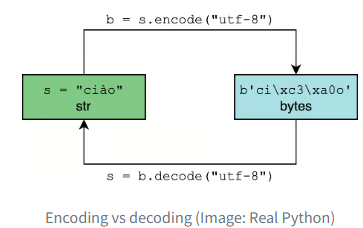


In `.encode()` and `.decode()`, the encoding parameter is "_utf-8_" by default. 

Though it is generally safer and more unambiguous to specify it. 

In [11]:
ic("résumé".encode("utf-8"))

ic("El Niño".encode("utf-8"))
ic("El Ni".encode("utf-8"))
ic("ñ".encode("utf-8"))


ic(b"r\xc3\xa9sum\xc3\xa9".decode(), b"El Ni\xc3\xb1o".decode())

ic| "résumé".encode("utf-8"): b'r\xc3\xa9sum\xc3\xa9'
ic| "El Niño".encode("utf-8"): b'El Ni\xc3\xb1o'
ic| "El Ni".encode("utf-8"): b'El Ni'
ic| "ñ".encode("utf-8"): b'\xc3\xb1'
ic| b"r\xc3\xa9sum\xc3\xa9".decode(): 'résumé'
    b"El Ni\xc3\xb1o".decode(): 'El Niño'


('résumé', 'El Niño')

This is why, when calling `"El Niño".encode("utf-8")`, the ASCII-compatible "El" is allowed to be represented as it is, but _the n with tilde_ is escaped to "\xc3\xb1". That messy-looking sequence represents two bytes, `0xc3` and `0xb1` in **hex**:

In [12]:
" ".join(f"{i:08b}" for i in (0xC3, 0xB1))

'11000011 10110001'

# Python3 Unicode Features
- Python 3 source code is assumed to be in UTF-8 by default.
- All text(`str`) is Unicode by default. 

In [13]:
import locale

locale.getpreferredencoding()

'UTF-8'

On windows 11 Korean, 

```python
>>> import locale
>>> locale.getpreferredencoding()
'cp949'
```

# One Byte, Two Bytes, Three Bytes, Four

A crucial feature is that UTF-8 is a **variable-length encoding**. It’s tempting to gloss over what this means, but it’s worth delving into.

Think back to the section on ASCII. Everything in extended-ASCII-land demands at most one byte of space. You can quickly prove this with the following generator expression:

In [16]:
all(len(chr(i).encode("ascii")) == 1 for i in range(128))

# for i in range(128):
#     print(len(chr(i)))


ibrow = "🤨"
ic(len(ibrow))
ic(len(ibrow.encode("utf-8")))

ic| len(ibrow): 1
ic| len(ibrow.encode('utf-8')): 4


4

Feature of `len()`

- The length of a single Unicode character as a Python str will always be 1, no matter how many bytes it occupies.
- The length of the same character encoded to bytes will be anywhere between 1 and **4**.

In [20]:
ic(b"0".decode())
ic("😓".encode())

b"\xf0\x9f\x98\x93".decode()

ic| b"0".decode(): '0'
ic| "😓".encode(): b'\xf0\x9f\x98\x93'


'😓'

In [23]:
# bytes("😓") # it does not work
bytes("😓", encoding="utf-8")

b'\xf0\x9f\x98\x93'

These can be logically grouped together based on their purpose:

- ascii(), bin(), hex(), and oct() are for obtaining a different representation of an input. Each one produces a str. The first, ascii(), produces an ASCII only representation of an object, with non-ASCII characters escaped. The remaining three give binary, hexadecimal, and octal representations of an integer, respectively. These are only representations, not a fundamental change in the input.

- bytes(), str(), and int() are class constructors for their respective types, bytes, str, and int. They each offer ways of coercing the input into the desired type. For instance, as you saw earlier, while int(11.0) is probably more common, you might also see int('11', base=16).

- ord() and chr() are inverses of each other in that the Python `ord()` function converts a str character to its base-10 code point, while `chr()` does the opposite.

- Here’s a more detailed look at each of these nine functions:

In [26]:
(ord("a"), chr(97))

(97, 'a')

In [41]:
# The Python ord() function converts a single Unicode character
# to its integer code point:

ord("ę")

281

In [27]:
# Hex example
hex(100)

'0x64'

In [28]:
(int("11"), int("11", base=2), int("11", base=8))

(11, 3, 9)

In [37]:
(
    int.from_bytes(b"\x0f\x0b"),
    int.from_bytes(b"\x0f\x0b", byteorder="big"),
    int.from_bytes(b"\x0f\x0b", byteorder="little"),
)

(3851, 3851, 2831)

In [40]:
ic("big endian:", 16**2 * 15 + 11)
ic("little endian:", 16**2 * 11 + 15)

ic| 'big endian:', 16**2 * 15 + 11: 3851
ic| 'little endian:', 16**2 * 11 + 15: 2831


('little endian:', 2831)

In [42]:
("a" == "\x61" == "\N{LATIN SMALL LETTER A}" == "\u0061" == "\U00000061")

True